In [387]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
%matplotlib inline

# For statistical tests and models
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA 
# For model evaluation
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

In [365]:
#import Tempreture data
df = pd.read_csv('../data/clean_SSHUM_sensor.csv')

# Data Preprocessing

In [366]:
df['Time'] = pd.to_datetime(df['Time'])
df.set_index('Time', inplace=True)
#df = df.asfreq('25s')


# Sort the DataFrame by time
df.sort_index(inplace=True)

In [367]:
df.head(-10)

,State,Device,Unit
Time,,,
2024-09-14 08:20:41,54.600000,SSHUM_sensor,C
2024-09-14 08:21:06,54.600000,SSHUM_sensor,C
2024-09-14 08:21:31,54.600000,SSHUM_sensor,C
2024-09-14 08:21:56,54.600000,SSHUM_sensor,C
2024-09-14 08:22:21,54.600000,SSHUM_sensor,C
...,...,...,...
2024-09-14 14:19:11,38.456970,SSHUM_sensor,C
2024-09-14 14:19:36,38.456970,SSHUM_sensor,C
2024-09-14 14:20:01,38.444509,SSHUM_sensor,C


In [368]:
df.isnull().sum()

State     0
Device    0
Unit      0
dtype: int64

In [369]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 874 entries, 2024-09-14 08:20:41 to 2024-09-14 14:25:01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   State   874 non-null    float64
 1   Device  874 non-null    object 
 2   Unit    874 non-null    object 
dtypes: float64(1), object(2)
memory usage: 27.3+ KB


In [352]:
df = df[::12]
df.head()

,State,Device,Unit
Time,,,
2024-09-12 01:04:03,13.000000,SSTEMP_sensor,C
2024-09-12 01:11:36,12.700000,SSTEMP_sensor,C
2024-09-12 01:17:34,12.618490,SSTEMP_sensor,C
2024-09-12 01:22:34,12.527746,SSTEMP_sensor,C
2024-09-12 01:27:34,12.413020,SSTEMP_sensor,C


In [370]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 874 entries, 2024-09-14 08:20:41 to 2024-09-14 14:25:01
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   State   874 non-null    float64
 1   Device  874 non-null    object 
 2   Unit    874 non-null    object 
dtypes: float64(1), object(2)
memory usage: 27.3+ KB


# Exploratory Data Analysis

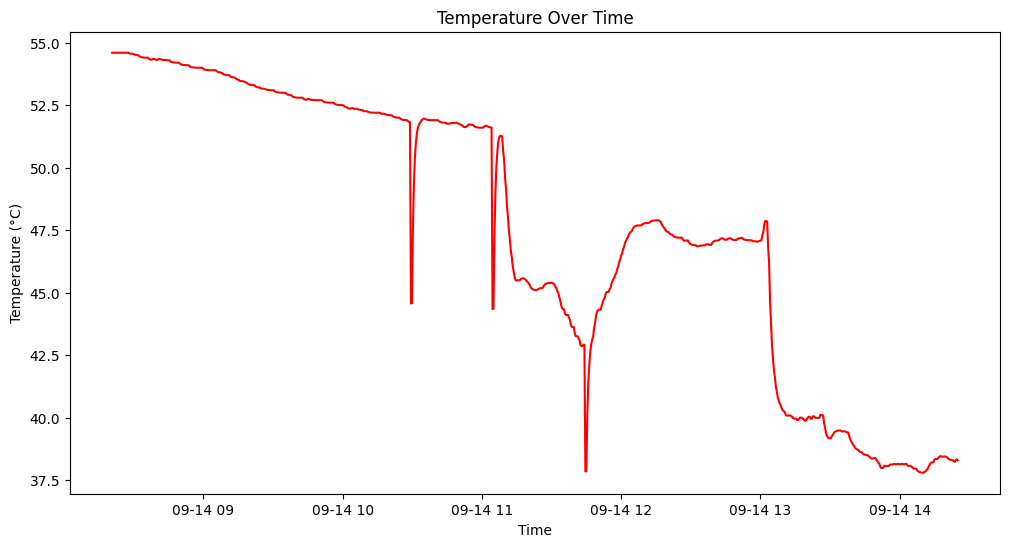

In [371]:
# Plot the time series
plt.figure(figsize=(12,6))
plt.plot(df['State'], color='red')
plt.title('Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.show()

#### The ADF test is used to check for stationarity in a time series. The hypotheses for the test are:

###### Null Hypothesis (H₀): The series has a unit root (non-stationary).
###### Alternative Hypothesis (H₁): The series is stationary.

In [372]:
# Function to perform Augmented Dickey-Fuller test
def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    for key, value in result[4].items():
        print('Critical Values:')
        print(f'   {key}, {value}')

adf_test(df['State'])

ADF Statistic: -0.692975
p-value: 0.848561
Critical Values:
   1%, -3.437897435722137
Critical Values:
   5%, -2.8648716746706326
Critical Values:
   10%, -2.568544030438542


## Key observations from results:

### p-value: 0.578778 (which is greater than 0.05)

##### Implication: We fail to reject the null hypothesis at the 5% significance level.
##### Conclusion: The series is non-stationary.

### ADF Statistic: -1.407286
##### Comparison with Critical Values: The ADF statistic is greater than all the critical values at 1%, 5%, and 10% levels.
###### Implication: This further indicates that we fail to reject the null hypothesis.

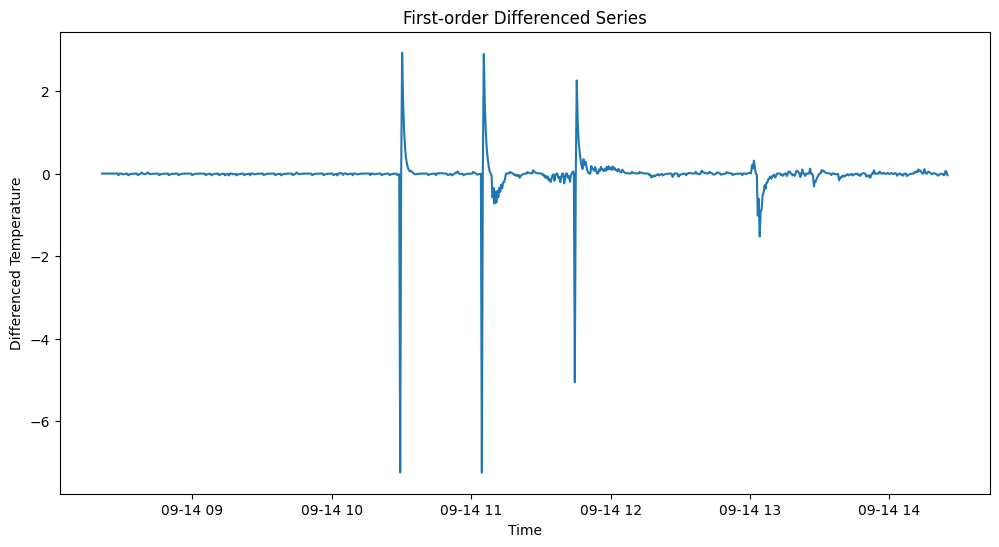

In [373]:
# First-order differencing
df_diff = df['State'].diff().dropna()

# Plot the differenced series
plt.figure(figsize=(12,6))
plt.plot(df_diff)
plt.title('First-order Differenced Series')
plt.xlabel('Time')
plt.ylabel('Differenced Temperature')
plt.show()

In [374]:
# Re-run ADF test on differenced series
adf_test(df_diff)

ADF Statistic: -17.274151
p-value: 0.000000
Critical Values:
   1%, -3.437897435722137
Critical Values:
   5%, -2.8648716746706326
Critical Values:
   10%, -2.568544030438542


#### p-value: 0.00000 < 0.05

##### Implication: We reject the null hypothesis.
##### Conclusion: The differenced series is stationary.
##### ADF Statistic: -13.817267

#### Comparison with Critical Values: The ADF statistic is less than all the critical values.
##### Implication: Strong evidence against the null hypothesis.

# Determining p and q
## I will be using ACF and PCAF plots

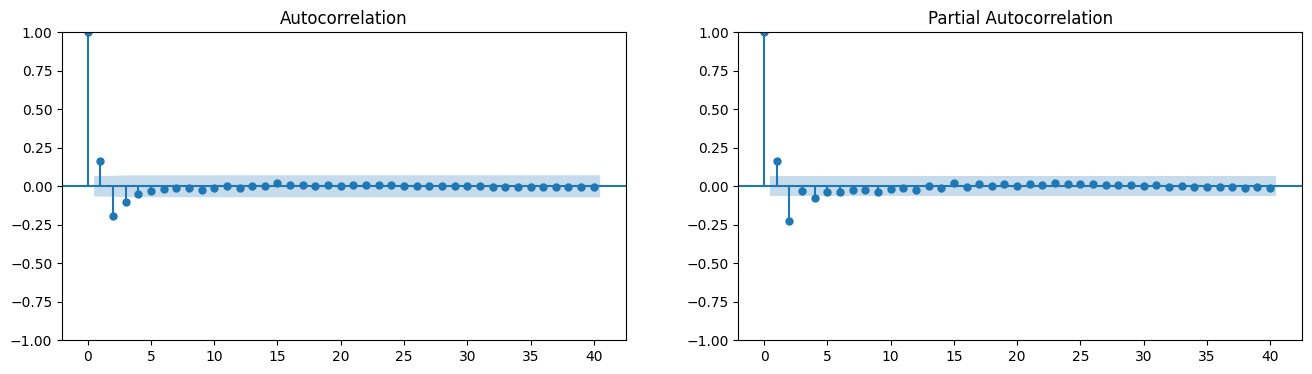

In [375]:
# Plot ACF and PACF
fig, axes = plt.subplots(1, 2, figsize=(16,4))
plot_acf(df_diff, lags=40, ax=axes[0])
plot_pacf(df_diff, lags=40, ax=axes[1])
plt.show()

## Autocorrelation Function (ACF):
#### Purpose: 
The ACF plot helps to determine the value of the Moving Average (MA) component, which is represented by q in ARIMA.

#### Observation:

There is a significant spike at lag 1, and then the autocorrelation gradually decreases.
After the first few lags, the spikes seem to level off around 0, indicating that there is no significant autocorrelation after a few lags.
This suggests that q = 1 is likely a good starting point for the MA term since the first lag has significant autocorrelation.

## Partial Autocorrelation Function (PACF):
#### Purpose:
The PACF plot helps to determine the value of the Autoregressive (AR) component, which is represented by p in ARIMA.

#### Observation:
There is a significant spike at lag 1, and after that, the partial autocorrelations drop off to near 0.
This indicates that p = 1 is likely a good choice for the AR term.

## Suggested ARIMA Model Parameters (p, d, q):
###### Based on the ACF and PACF plots:
###### p (AR order): 1 (because of the sharp cutoff at lag 1 in the PACF)
###### d (Differencing order): 1 (since you've differenced the series once to achieve stationarity)
###### q (MA order): 1 (because of the significant spike at lag 1 in the ACF)

#### Thus, the tentative ARIMA model could be ARIMA(1, 1, 1).



# Split Data into Training and Testing sets

In [376]:
train_size = int(len(df) * 0.8)
train, test = df['State'][:train_size], df['State'][train_size:]

# Model Training

In [377]:
# Fit the ARIMA model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

# Print summary of the model
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                  State   No. Observations:                  699
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -487.742
Date:                Sat, 14 Sep 2024   AIC                            981.484
Time:                        14:35:07   BIC                            995.128
Sample:                             0   HQIC                           986.759
                                - 699                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3514      0.042     -8.306      0.000      -0.434      -0.268
ma.L1          0.5806      0.037     15.856      0.000       0.509       0.652
sigma2         0.2368      0.001    166.247      0.0

/home/tiaan/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/tiaan/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/tiaan/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


# Model Summary Interpretation
## Model: 
ARIMA(1, 1, 1), which fits one autoregressive term (p=1), one differencing term (d=1), and one moving average term (q=1).

### AIC: -22536.222
Lower AIC values indicate better model fit. This value is negative, which is a good sign that the model fits well.

### Log Likelihood: 11271.111
This measures the likelihood of the data given the model. A higher log likelihood is better.

### BIC: -22516.688
Similar to AIC, but penalizes models with more parameters more heavily. Again, a lower value is better.

### HQIC: -22529.374
Another criterion like AIC and BIC, but used less frequently.

### Coefficients:

#### ar.L1 (Autoregressive lag 1 coefficient): 0.7132
This indicates the strength of the autoregressive part of the model. A coefficient of 0.7132 suggests that the past value influences the current value, with positive autocorrelation at lag 1.
#### ma.L1 (Moving Average lag 1 coefficient): 0.0486
This is the coefficient for the moving average part, which is relatively small compared to the AR component, indicating a weaker contribution from the moving average part.
#### sigma2 (Variance of the residuals): 0.0006
This is the variance of the model's residuals (errors), which is small, indicating a good fit to the data.
#### Jarque-Bera (JB): 19865.47 with Prob(JB) = 0.00
This tests whether the residuals are normally distributed. Since the p-value is 0.00, the null hypothesis (that the residuals are normally distributed) is rejected. This suggests that there may be some non-normality in the residuals.
#### Skew: -0.47
This indicates that the residuals are slightly skewed to the left.
#### Kurtosis: 12.75
This is higher than 3, indicating that the residuals have heavy tails (leptokurtic distribution), meaning there may be some extreme values in the data.
#### Ljung-Box Q statistic (L1): 0.01 with Prob(Q) = 0.90
This test checks if the residuals are autocorrelated at lag 1. Since the p-value is much greater than 0.05, we fail to reject the null hypothesis, meaning that there is no significant autocorrelation in the residuals at lag 1.

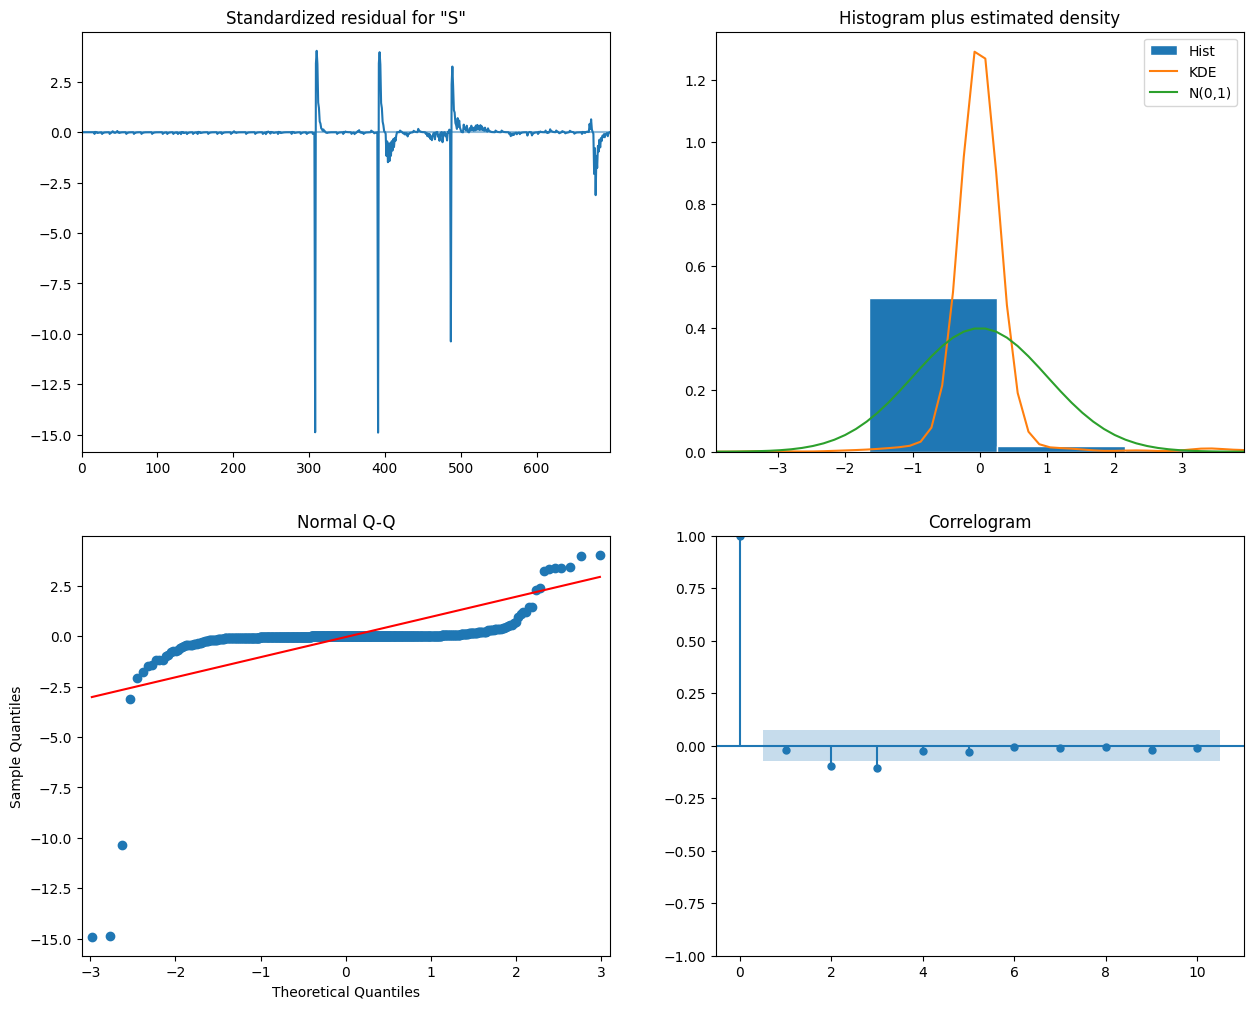

In [378]:
model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

/home/tiaan/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/tiaan/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/tiaan/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                  State   No. Observations:                  699
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -477.245
Date:                Sat, 14 Sep 2024   AIC                            962.491
Time:                        14:35:10   BIC                            980.684
Sample:                             0   HQIC                           969.524
                                - 699                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5430      0.076      7.121      0.000       0.394       0.692
ma.L1         -0.3587      0.075     -4.754      0.000      -0.507      -0.211
ma.L2         -0.3029      0.019    -15.805      0.0

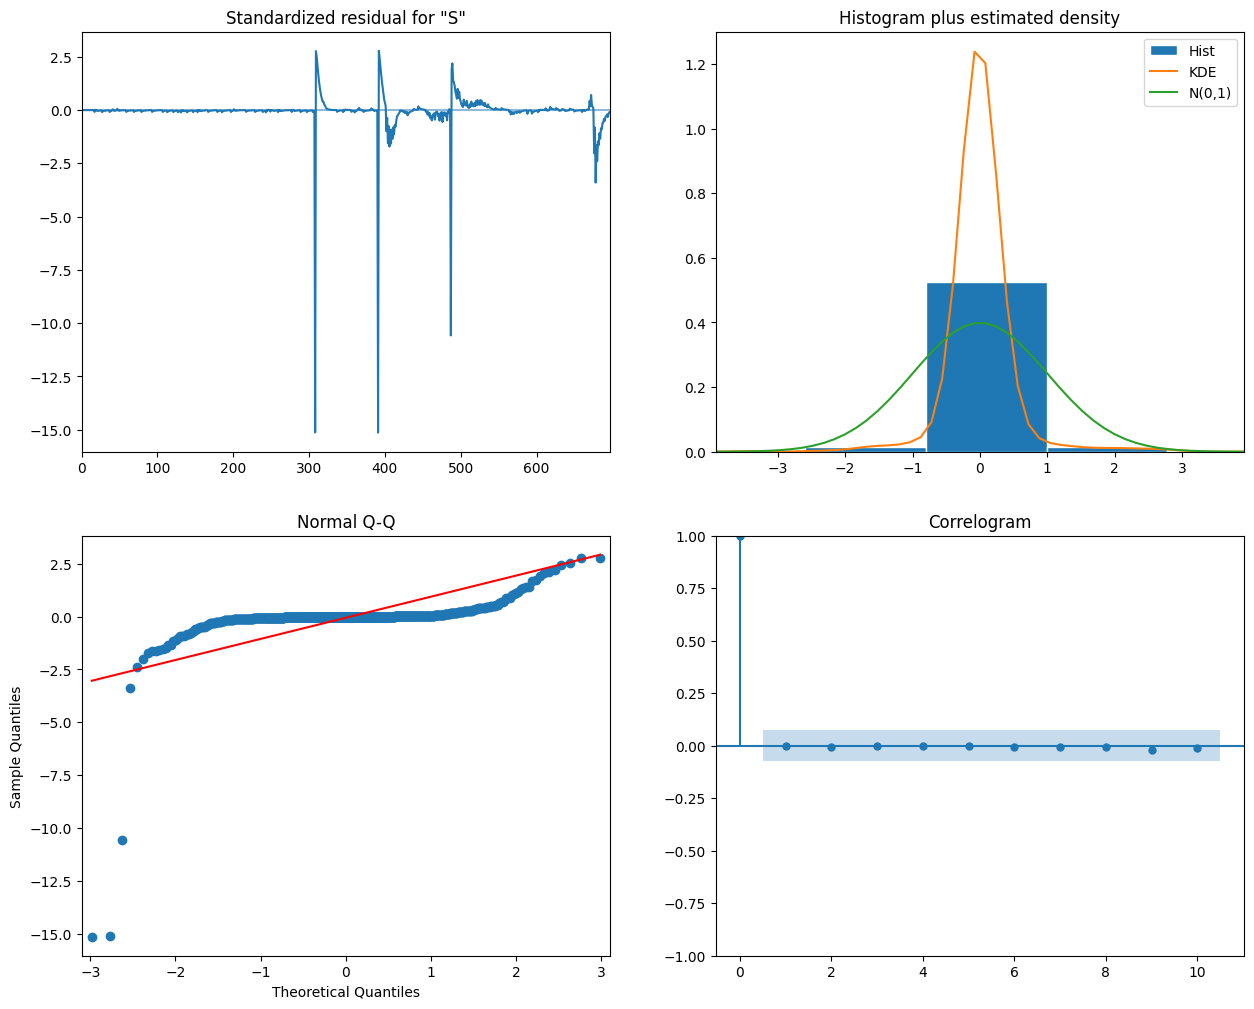

In [379]:
# Fit ARIMA(1,1,2)
new_model = ARIMA(train, order=(1, 1, 2))
new_model_fit = new_model.fit()

# Print model summary
print(new_model_fit.summary())

# Plot diagnostics for the new model
new_model_fit.plot_diagnostics(figsize=(15, 12))
plt.show()

# Model Testing and evaluation:

/home/tiaan/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


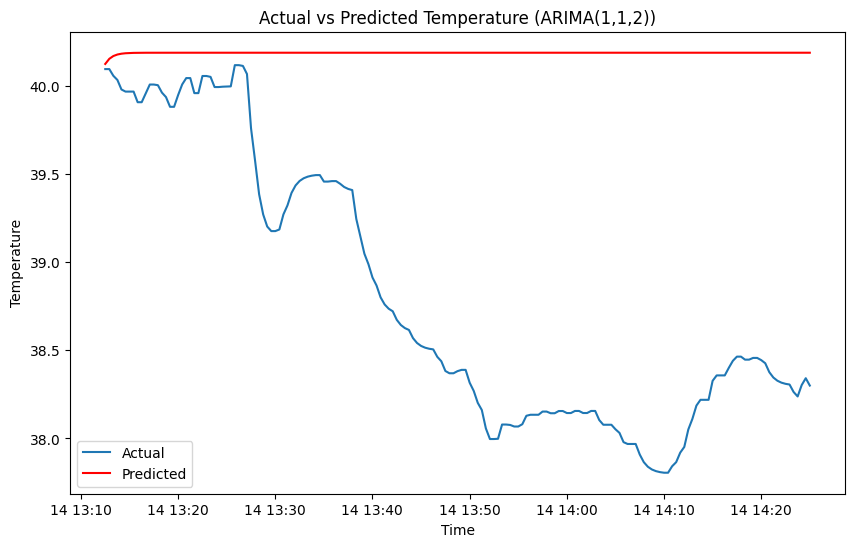

MSE: 2.524382343046591
MAE: 1.3900040873070965


In [381]:
# Forecast values for the test data
start = len(train)
end = len(train) + len(test) - 1
predictions = new_model_fit.forecast(steps=len(test))


# Plot actual vs predicted
plt.figure(figsize=(10,6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.title('Actual vs Predicted Temperature (ARIMA(1,1,2))')
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.legend()
plt.show()

# Calculate error metrics (MSE, MAE)
mse = mean_squared_error(test, predictions)
mae = mean_absolute_error(test, predictions)
print(f'MSE: {mse}')
print(f'MAE: {mae}')

In [408]:
df = pd.read_csv('../data/clean_SSHUM_sensor.csv')

In [409]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 874 entries, 0 to 873
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   State   874 non-null    float64
 1   Time    874 non-null    object 
 2   Device  874 non-null    object 
 3   Unit    874 non-null    object 
dtypes: float64(1), object(3)
memory usage: 27.4+ KB


In [410]:
# Ensure 'Time' is datetime
df['Time'] = pd.to_datetime(df['Time'])

# Set 'Time' as the index
df.set_index('Time', inplace=True)

# Sort the DataFrame by index (time)
df.sort_index(inplace=True)



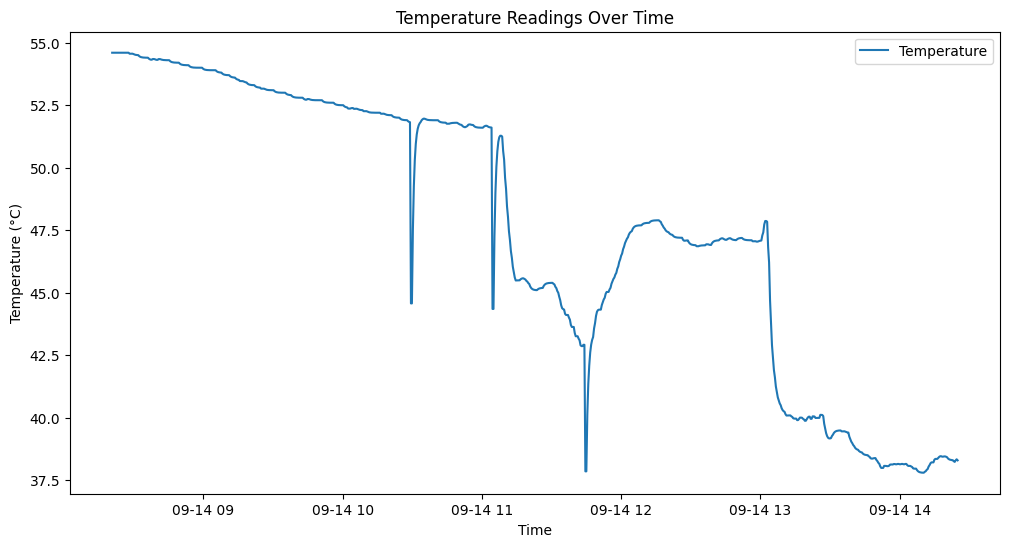

In [411]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['State'], label='Temperature')
plt.title('Temperature Readings Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.show()

In [412]:
# Define the number of lags
n_lags = 1  # You can experiment with different numbers

# Create lagged features
for lag in range(1, n_lags + 1):
    df[f'lag_{lag}'] = df['State'].shift(lag)

# Drop rows with NaN values resulting from shifting
df.dropna(inplace=True)

In [413]:
# Define the size of the training set (e.g., 80% for training)
train_size = int(len(df) * 0.8)

# Split the data
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Display the sizes
print(f'Training set size: {len(train)}')
print(f'Testing set size: {len(test)}')

Training set size: 698
Testing set size: 175


In [414]:
# Predictors (features)
X_train = train[['lag_1']]
X_test = test[['lag_1']]

# Target variable
y_train = train['State']
y_test = test['State']

In [415]:
# Create the model
model = LinearRegression()

# Fit the model
model.fit(X_train, y_train)

# Display model coefficients
print(f'Intercept: {model.intercept_}')
print(f'Coefficient: {model.coef_[0]}')

Intercept: 0.2282418147613967
Coefficient: 0.9950071028023528


In [417]:
predictions = model.predict(X_test)
# Calculate MSE and MAE
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Mean Absolute Error (MAE): {mae:.4f}")

Mean Squared Error (MSE): 0.0045
Mean Absolute Error (MAE): 0.0527


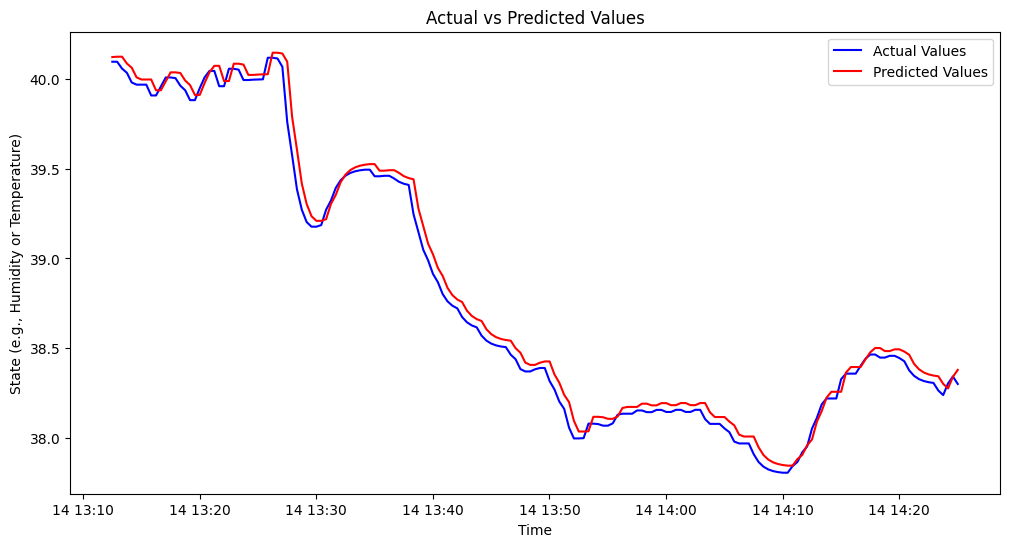

In [418]:
# Plot the actual vs predicted values
plt.figure(figsize=(12, 6))

# Plot actual values (ground truth)
plt.plot(y_test.index, y_test, label='Actual Values', color='blue')

# Plot predicted values
plt.plot(y_test.index, predictions, label='Predicted Values', color='red')

# Add labels and title
plt.title('Actual vs Predicted Values')
plt.xlabel('Time')
plt.ylabel('State (e.g., Humidity or Temperature)')
plt.legend()

# Show the plot
plt.show()

In [ ]:
residuals = y_test - predictions